# Part 1: Data Collection

In [1]:
# Extract data from 2013 to 2015 (for all 12 months) from https://en.tutiempo.net/climate/01-2013/ws-421820.html

# ~30 days * 12 months * 3 years = ~1080 rows of data

# From the above link, every page will give data for one month. 
# Hence we need to alter the month and year in the URL to fetch data for all the years and months

In [2]:
# Collecting and saving the html files in local storage

In [3]:
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import pandas_profiling as pp
import numpy as np
import os
import time
import warnings
warnings.filterwarnings('ignore')

In [4]:
import random
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm 
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn import preprocessing, metrics, tree
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.tree import export_graphviz

from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor 

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR

from yellowbrick.classifier import ROCAUC, roc_auc
from yellowbrick.features import RadViz

from IPython.display import Image  

import pydotplus
from urllib.request import urlopen 
from itertools import cycle
%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_columns', 500) 

In [5]:
def retrieve_html(start_year, end_year):
    for year in range (start_year, end_year+1):
        for month in range (1, 13):
            if month<10:
                url = f'https://en.tutiempo.net/climate/0{month}-{year}/ws-421820.html'
            else:
                url = f'https://en.tutiempo.net/climate/{month}-{year}/ws-421820.html'
                
            data = requests.get(url, verify = False).text

            # Create Directory Structure to save the html files
            if not os.path.exists(f'Data/html_data/{year}'): 
                os.makedirs(f'Data/html_data/{year}')

            # File Handling - Save all the html data as html files
            if month<10:
                with open(f'Data/html_data/{year}/0{month}.html', 'w') as f:
                    f.write(data)
            else:
                with open(f'Data/html_data/{year}/{month}.html', 'w') as f:
                    f.write(data)

In [6]:
# Create a folder structure to store the data so that we can work offline:

# data
#     - html_data
#                - 2013
#                      - 01.html
#                      - 02.html
#                      - 03.html

In [7]:
# # Call function to retrieve HTML data from the url. Comment it out afterwards.
# # Note: Internet connection is needed to execute this:

# start_time = time.time()
# retrieve_html(2013, 2015)
# end_time = time.time()
# print("Done, Total Time: ", end_time - start_time)

# Part 2: Collecting Target Variable

In [8]:
# Next, refer to AQI data in Data\AQI\aqi2013.csv, aqi2014.csv, aqi2015.csv
# This file has hourly data. We need to take the mean of hourly data to fetch daily data
# We need to treat the missing values as well

In [9]:
average = []

def avg_data(path):    

    # Read the data
    for rows in pd.read_csv(path, chunksize = 24):       # chunksize defines number of rows
        add_var = 0
        n = 0
        data1 = []
        df = pd.DataFrame(data = rows)
        #print(df)

        for _, row in df.iterrows():      # Tuple unpacking: _, row --> row has the 2nd item separated from the 1st value by ','
                                          # We use _ to save memory by not assigning the 1st value to any variable
            data1.append(row['PM2.5'])    # We need only the data in series 'PM2.5'    
            date = row['Date']
        #print(date, data1)

        for i in data1:
            if type(i) is float or type(i) is int:
                add_var += i
                n += 1

            elif type(i) is str:
                if i != 'NoData' and i != 'PwrFail' and i != '---' and i != 'InVld':
                    add_var += float(i)
                    n += 1

        if n==0:                     # n is the number of valid values for each date which may or may not be 24
            n = 1                    # Change the value of n to 1 if it is 0 to avoid Zero Division Error
            
        average.append((date.split()[0], add_var/n))    # The division should be by the actual number of values available for that day and not by 24 as there are missing values


#     print("Number of days for which data is available: ", len(average))
#     print(average)               

In [10]:
# Call the above function for all values of 'year' in the required range

target = []
c = 2013
for _, _, files in os.walk('Data/AQI/'):
    for file in files:        
        if file.endswith(".csv"):
            pth = 'Data/AQI/' + file
            print(pth)
            avg_data(pth)
            #target.append(avg_data(pth))
            #print(file)
            #print("Length of Year :", c, ": ", len(target[c-2013]))
            c = c + 1

#print("\n", average)

Data/AQI/aqi2013.csv
Data/AQI/aqi2014.csv
Data/AQI/aqi2015.csv


In [11]:
final_target = pd.DataFrame(average, index = None, columns = ['Date', 'PM2.5'])
#final_target.to_csv('sample.csv')
final_target

,Date,PM2.5
0,01/01/2013,284.795833
1,02/01/2013,239.695455
2,03/01/2013,182.187500
3,04/01/2013,197.635714
4,05/01/2013,0.000000
...,...,...
1089,27/12/2015,255.333333
1090,28/12/2015,199.916667
1091,29/12/2015,190.500000
1092,30/12/2015,217.727273


# Part 3: Read and Consolidate the Independent Variables

In [12]:
df_res = pd.DataFrame()
# Extract all the folder names in the directory 'Data\\html_data\\':
for _, dirs, _ in os.walk('Data\\html_data\\'):
    break

# Extract all the file names in each folder:
for sub_dir in dirs:
    for _, _, files in os.walk('Data\\html_data\\' + sub_dir):
        for file in files:
            path = os.path.join('Data\\html_data\\', sub_dir, file)
            #print(path)            
            
            with open(path, 'r') as page:
                soup = bs(page)
                table = soup.find('table', {'class':'medias mensuales numspan'})
                
                daily_data = []
                for rows in table.find_all('td'):  
                    daily_data.append(rows.text)
                    
                res_daily_data = []
                daily = []
                n = 0

                for val in daily_data:
                    if n<=13:
                        n = n + 1
                        res_daily_data.append(val)
                        
                    else:
                        daily.append(res_daily_data)
                        res_daily_data = []
                        n = 0
                        continue
                
                df = pd.DataFrame(daily, index = None, columns = ['Day', 
                                                                  'Average Temperature',
                                                                  'Maximum temperature',
                                                                  'Minimum temperature', 
                                                                  'Atmospheric pressure at sea level (hPa)', 
                                                                  'Average relative humidity', 
                                                                  'Total rainfall and / or snowmelt (mm)', 
                                                                  'Average visibility (Km)', 
                                                                  'Average wind speed (Km/h)', 
                                                                  'Maximum sustained wind speed (Km/h)', 
                                                                  'VG', 'RA', 'SN', 'TS'])
                
                df['Day'] = df['Day'].astype(str).str.zfill(2)
                df['Date'] = df['Day'] + '/' + file.split('.')[0] + '/' + sub_dir
                df = df[:-1]
                df = df[['Date', 
                         'Average Temperature',
                         'Maximum temperature',
                         'Minimum temperature', 
                         'Atmospheric pressure at sea level (hPa)', 
                         'Average relative humidity', 
                         'Total rainfall and / or snowmelt (mm)', 
                         'Average visibility (Km)', 
                         'Average wind speed (Km/h)', 
                         'Maximum sustained wind speed (Km/h)', 
                         'VG', 'RA', 'SN', 'TS']]
                #print (df)
                df_res = df_res.append(df)
                
final_features = df_res.iloc[:, :10] 
final_features.to_csv('independent_variables.csv', index = None)
final_features.head(10)

,Date,Average Temperature,Maximum temperature,Minimum temperature,Atmospheric pressure at sea level (hPa),Average relative humidity,Total rainfall and / or snowmelt (mm),Average visibility (Km),Average wind speed (Km/h),Maximum sustained wind speed (Km/h)
0,01/01/2013,9.1,15.3,4,1015.6,90,0,0.5,0,-
1,02/01/2013,7.4,9.8,4.8,1017.6,93,0,0.5,4.3,9.4
2,03/01/2013,7.8,12.7,4.4,1018.5,87,0,0.6,4.4,11.1
3,04/01/2013,,,,,,,,,
4,05/01/2013,,,,,,,,,
5,06/01/2013,,,,,,,,,
6,07/01/2013,6.7,13.4,2.4,1019.4,82,0,0.6,4.8,11.1
7,08/01/2013,8.6,15.5,3.3,1018.7,72,0,0.8,8.1,20.6
8,09/01/2013,12.4,20.9,4.4,1017.3,61,0,1.3,8.7,22.2
9,10/01/2013,,,,,,,,,


# Part 4: Merge the Independent and Dependent Variables into a single DataFrame

In [13]:
final_df = pd.merge(final_features, final_target, on ='Date', how ='inner')
final_df.head(10)

,Date,Average Temperature,Maximum temperature,Minimum temperature,Atmospheric pressure at sea level (hPa),Average relative humidity,Total rainfall and / or snowmelt (mm),Average visibility (Km),Average wind speed (Km/h),Maximum sustained wind speed (Km/h),PM2.5
0,01/01/2013,9.1,15.3,4,1015.6,90,0,0.5,0,-,284.795833
1,02/01/2013,7.4,9.8,4.8,1017.6,93,0,0.5,4.3,9.4,239.695455
2,03/01/2013,7.8,12.7,4.4,1018.5,87,0,0.6,4.4,11.1,182.187500
3,04/01/2013,,,,,,,,,,197.635714
4,05/01/2013,,,,,,,,,,0.000000
5,06/01/2013,,,,,,,,,,297.100000
6,07/01/2013,6.7,13.4,2.4,1019.4,82,0,0.6,4.8,11.1,264.064286
7,08/01/2013,8.6,15.5,3.3,1018.7,72,0,0.8,8.1,20.6,223.208333
8,09/01/2013,12.4,20.9,4.4,1017.3,61,0,1.3,8.7,22.2,200.645833
9,10/01/2013,,,,,,,,,,154.875000


# Replace Null and Zero Values with Median Value

In [14]:
# Replace empty cells in 'Average Temperature' column with NAN and drop those rows:
final_df['Average Temperature'].replace('', np.nan, inplace = True)
final_df.dropna(subset=['Average Temperature'], inplace=True)

# Replace values '-' with NAN
final_df.replace('-', np.nan, inplace = True)

# Replace values 0 with NAN
final_df.replace(0, np.nan, inplace = True)

# Replace all NAN Values with median value for all columns
final_df = final_df.fillna(final_df.median())

# Save the final dataframe as a csv file for later reference
final_df.to_csv('cleaned_data.csv', index = None)
final_df.head()

,Date,Average Temperature,Maximum temperature,Minimum temperature,Atmospheric pressure at sea level (hPa),Average relative humidity,Total rainfall and / or snowmelt (mm),Average visibility (Km),Average wind speed (Km/h),Maximum sustained wind speed (Km/h),PM2.5
0,01/01/2013,9.1,15.3,4,1015.6,90,0,0.5,0,14.8,284.795833
1,02/01/2013,7.4,9.8,4.8,1017.6,93,0,0.5,4.3,9.4,239.695455
2,03/01/2013,7.8,12.7,4.4,1018.5,87,0,0.6,4.4,11.1,182.187500
6,07/01/2013,6.7,13.4,2.4,1019.4,82,0,0.6,4.8,11.1,264.064286
7,08/01/2013,8.6,15.5,3.3,1018.7,72,0,0.8,8.1,20.6,223.208333


In [15]:
# Check for NaN Values:
final_df.isnull().values.any()

False

# Exploratory Data Analysis

In [16]:
report = pp.ProfileReport(final_df)
report.to_file('Data/profile_report.html')
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
final_df = final_df.drop(['Date'], axis = 1)
final_df = final_df.astype(float)
final_df.dtypes

Average Temperature                        float64
Maximum temperature                        float64
Minimum temperature                        float64
Atmospheric pressure at sea level (hPa)    float64
Average relative humidity                  float64
Total rainfall and / or snowmelt (mm)      float64
Average visibility (Km)                    float64
Average wind speed (Km/h)                  float64
Maximum sustained wind speed (Km/h)        float64
PM2.5                                      float64
dtype: object

# Feature Importance

In [18]:
# Gives us the score for each feature of the data. The higher the score, the more important is the feature
# Purpose: To avoid dropping or manipulating the most important features

In [19]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor()

X1 = final_df.iloc[:, :-1]
Y1 = final_df.iloc[:,-1]

model.fit(X1, Y1)

fi = pd.DataFrame(list(zip(final_df.columns[0:-1], model.feature_importances_))).T
fi

,0,1,2,3,4,5,6,7,8
0,Average Temperature,Maximum temperature,Minimum temperature,Atmospheric pressure at sea level (hPa),Average relative humidity,Total rainfall and / or snowmelt (mm),Average visibility (Km),Average wind speed (Km/h),Maximum sustained wind speed (Km/h)
1,0.103893,0.056808,0.14245,0.097,0.056244,0.031803,0.424745,0.054892,0.032165


# Plot Correlation Matrix to visualize the degree of Correlation between variables

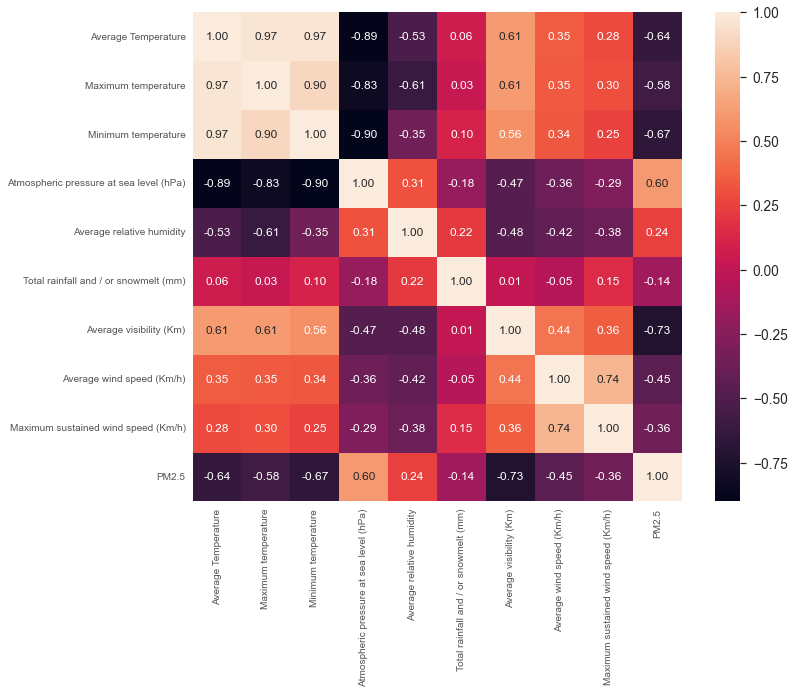

In [20]:
# Create Correlation Matrix
corrmat = final_df.corr()

# Attrition correlation matrix
cols = corrmat.columns

# Correlation Matrix
cm = np.corrcoef(final_df[cols].values.T)
f, ax = plt.subplots(figsize=(12, 9))
sns.set(font_scale=1.25)

# Plot the Heatmap
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [21]:
# Drop strongly correlated variables (i.e. correlation coefficient > 0.75 or < -0.75)

final_df = final_df.drop(['Minimum temperature'], axis = 1)
final_df = final_df.drop(['Maximum temperature'], axis = 1)
# final_df = final_df.drop(['Average Temperature'], axis = 1)
final_df = final_df.drop(['Atmospheric pressure at sea level (hPa)'], axis = 1)
final_df = final_df.drop(['Maximum sustained wind speed (Km/h)'], axis = 1)
#final_df = final_df.drop(['Total rainfall and / or snowmelt (mm)'], axis = 1)

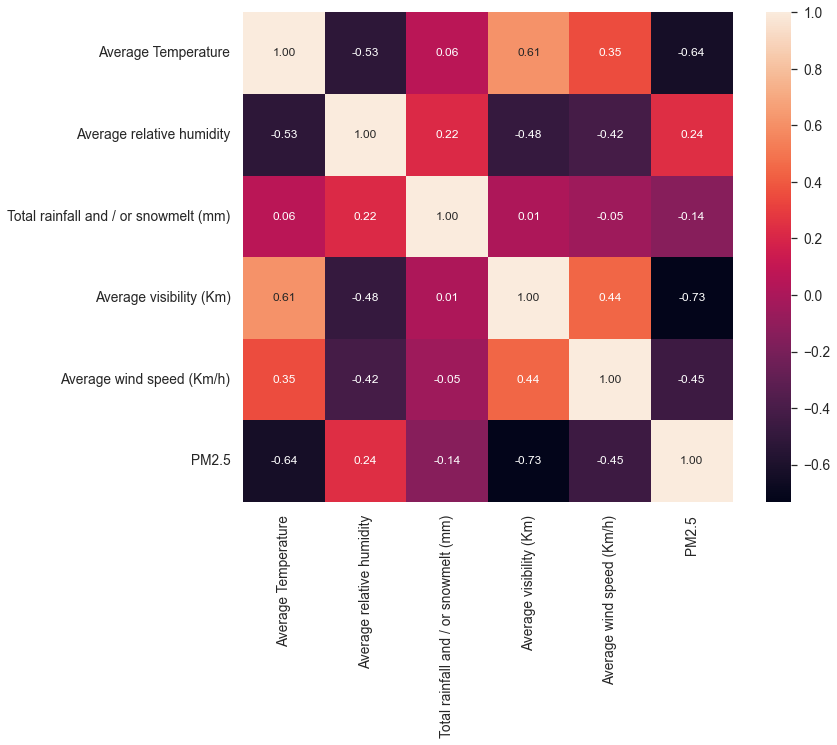

In [22]:
# Create Correlation Matrix
corrmat = final_df.corr()

# Attrition correlation matrix
cols = corrmat.columns

# Correlation Matrix
cm = np.corrcoef(final_df[cols].values.T)
f, ax = plt.subplots(figsize=(12, 9))
sns.set(font_scale=1.25)

# Plot the Heatmap
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# Outlier Treatment

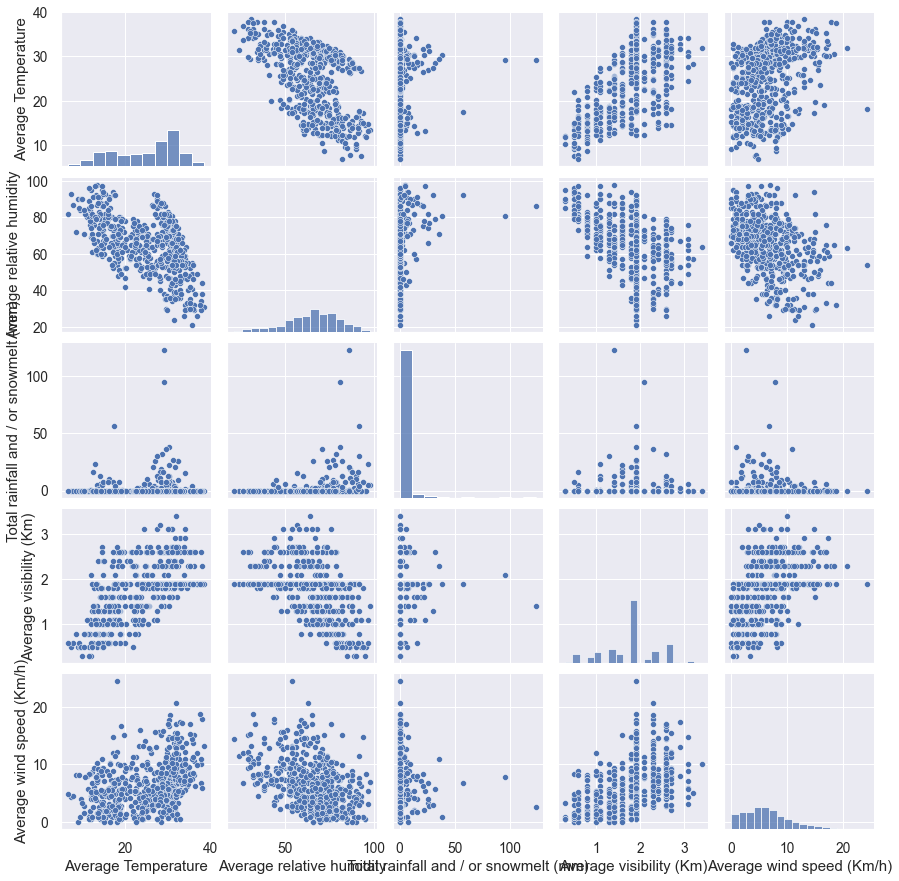

In [23]:
sns.pairplot(final_df.drop(['PM2.5'], axis = 1))
plt.show()

In [24]:
# Outlier Treatment:
# Keep only those rows where the Z Score of all columns is < 3. 
# Basically drop all rows where Z Score value of at least 1 column >= 3

final_df=final_df[(np.abs(stats.zscore(final_df)) < 3).all(axis=1)]

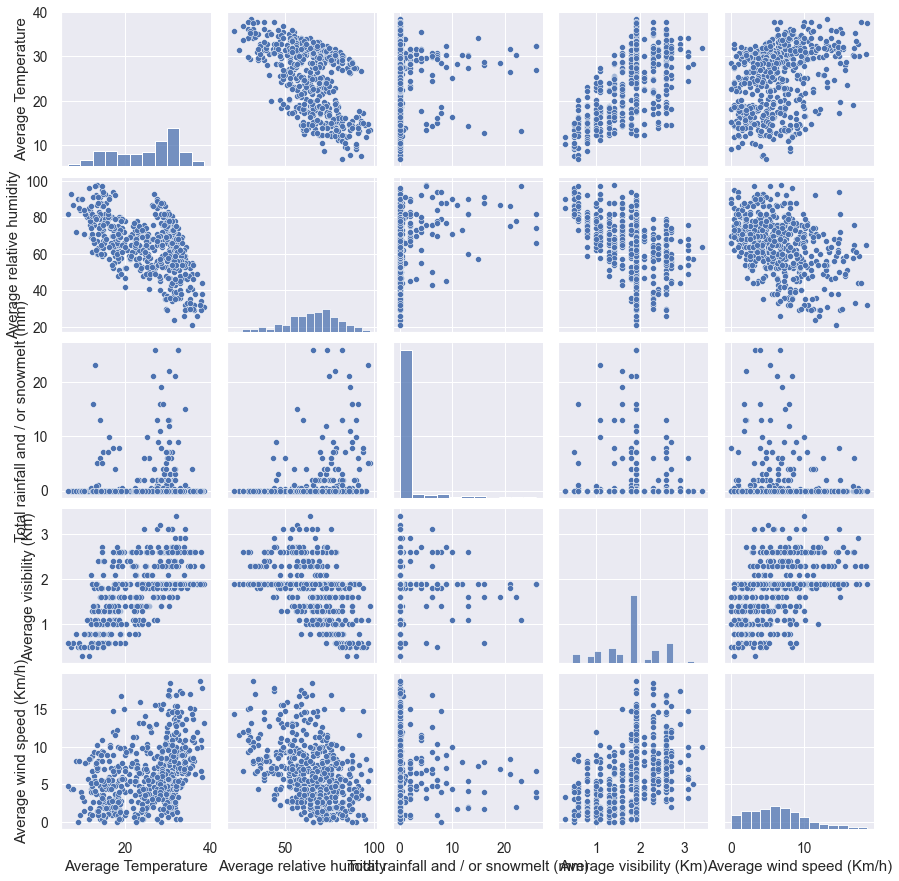

In [25]:
sns.pairplot(final_df.drop(['PM2.5'], axis = 1))
plt.show()

# Feature Scaling & Standardization

In [26]:
# Save the Target Variable "quality" in variable y before standardization as Target Variable should not be standardised
y = final_df.iloc[:, final_df.columns == 'PM2.5']

In [27]:
cols = list(final_df.columns)
l = len(cols)-1
cols = cols[0:l]

data = final_df.drop('PM2.5', axis = 1).values  

#standardize the data to normal distribution
dataset1_standardized = preprocessing.scale(data)
encoded_df1 = pd.DataFrame(dataset1_standardized, columns = cols)    # encoded_df1 is the dataset without the target variable
#encoded_df1.head(20)

In [28]:
# Save the standardised values of variables in x
x = encoded_df1.values

# Train Test Split

In [29]:
# Split the dataset for training and testing

x_train1, x_test1, y_train1, y_test1 = train_test_split(x, y, test_size = 0.2, random_state = 42)
# Cleaning test sets to avoid future warning messages
y_train1 = y_train1.values.ravel() 
y_test1 = y_test1.values.ravel() 

# +++++++++++++++++++++++++++++++++++++++++++++++++++++

# Random Forest Regressor

In [30]:
# Random Forest Classifier: Set the random state for reproducibility
fit_rf = RandomForestRegressor(random_state=42)

# Hyper-Parameter Optimization using GridSearchCV (Cross Validation)

In [31]:
# # Execute this code snippet only to find the optimal values of parameters. Comment it out afterwards
# # Automatically find the best parameters instead of manual hit and try

# np.random.seed(42)
# start = time.time()

# param_dist = {'max_depth': [5, 6, 7, 8, 9, 10, 11, 12],
#               'bootstrap': [True],
#               'max_features': ['auto', None],
#               'criterion': ['squared_error', 'absolute_error', 'poisson'],
#               'min_samples_split' : [3, 4, 5, 6],
#               'min_samples_leaf' : [2, 3, 4, 5, 6]}

# # Here we can add 'n_estimator' : [400, 500, 600], 'min_samples_split' : [5, 10, 15, 20], 'min_samples_leaf' : [2, 3, 4, 5] 
# # but that will consume lot of resources and increase computational time
# # Hence calculate OOB Error Rate and manually put the n_estimator value later
# # n_jobs should be 1 less than number of CPU cores. -1 means all cores
# cv_rf = GridSearchCV(fit_rf, cv = 10, param_grid=param_dist, n_jobs = -1)    

# cv_rf.fit(x_train1, y_train1)
# print('Best Parameters using grid search: \n', cv_rf.best_params_)
# print('Best Parameters using grid search: \n', cv_rf.get_params)
# end = time.time()
# print('Time taken in grid search: {0: .2f}'.format(end - start))

In [32]:
# Best Parameters using grid search: 
#  {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': 12, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 6}
# Best Parameters using grid search: 
#  <bound method BaseEstimator.get_params of GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
#              param_grid={'bootstrap': [True],
#                          'criterion': ['squared_error', 'absolute_error',
#                                        'poisson'],
#                          'max_depth': [5, 6, 7, 8, 9, 10, 11, 12],
#                          'max_features': ['auto', None],
#                          'min_samples_leaf': [2, 3, 4, 5, 6],
#                          'min_samples_split': [3, 4, 5, 6]})>
# Time taken in grid search:  258.73

# OOB (Out of Bag) Error Rate

In [33]:
# # OOB: Rows / Columns that are not included in a certain random sample. 
# # The model has no visibility to such records in that particular decision tree being created
# # as they are not exposed to that data

# fit_rf.set_params(warm_start=False, oob_score=True)
 
# min_estimators = 15
# max_estimators = 1000
# error_rate = {}
# for i in range(min_estimators, max_estimators + 1):
#     fit_rf.set_params(n_estimators=i)
#     fit_rf.fit(x_train1, y_train1)
#     oob_error = 1 - fit_rf.oob_score_
#     error_rate[i] = oob_error
    
# # Convert dictionary to a pandas series for easy plotting 
# oob_series = pd.Series(error_rate)


# fig, ax = plt.subplots(figsize=(25, 6))

# ax.set_facecolor('#fafafa')
# oob_series.plot(kind='line',color = 'red')
# plt.xlabel('n_estimators')
# plt.ylabel('OOB Error Rate')
# plt.title('OOB Error Rate Across various Forest sizes \n(From 15 to 500 trees)')
# plt.grid(color = 'blue', linestyle = '--', linewidth = 0.5)

In [34]:
# print('OOB Error rate for 380 trees is: {0:.5f}'.format(oob_series[180]))

In [35]:
# Refine the tree via OOB Output for n_estimators
# n_estimators is the number of trees we want to build before taking the maximum voting or averages of predictions
# Set best parameters given by grid search 

fit_rf.set_params(max_depth=12, 
                  criterion='squared_error', 
                  min_samples_split=6, 
                  min_samples_leaf=2,
                  max_features = 'auto',
                  n_estimators=180,
                  bootstrap = True,
                  warm_start=False, 
                  oob_score=True)

# Train the Random Forest
fit_rf.fit(x_train1, y_train1)

model_rf_score_train = fit_rf.score(x_train1, y_train1)
print("Training score: ", model_rf_score_train)

model_rf_score_test = fit_rf.score(x_test1, y_test1)
print("Testing score: ",model_rf_score_test)

Training score:  0.8898909685147955
Testing score:  0.8159569639168125


In [36]:
y_pred_rf = fit_rf.predict(x_test1)

In [37]:
print('Mean Absolute Error (MAE)            :', metrics.mean_absolute_error(y_test1, y_pred_rf))
print('Mean Squared Error (MSE)             :', metrics.mean_squared_error(y_test1, y_pred_rf))
print('Root Mean Squared Error (RMSE)       :', metrics.mean_squared_error(y_test1, y_pred_rf, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_test1, y_pred_rf))
print('Explained Variance Score             :', metrics.explained_variance_score(y_test1, y_pred_rf))
print('Max Error                            :', metrics.max_error(y_test1, y_pred_rf))
print('Median Absolute Error                :', metrics.median_absolute_error(y_test1, y_pred_rf))
print('R^2                                  :', metrics.r2_score(y_test1, y_pred_rf))

Mean Absolute Error (MAE)            : 27.850338497899813
Mean Squared Error (MSE)             : 1376.1637838478634
Root Mean Squared Error (RMSE)       : 37.096681574608034
Mean Absolute Percentage Error (MAPE): 0.33095515944916826
Explained Variance Score             : 0.816535918012295
Max Error                            : 137.95414331787515
Median Absolute Error                : 21.819490707695863
R^2                                  : 0.8159569639168125


In [38]:
# Create the Final Output Dataframe

final_output_rf = pd.DataFrame(x_test1)
final_output_rf['Actual PM2.5'] = y_test1
final_output_rf['Predicted_PM2.5'] = y_pred_rf
final_output_rf['Percentage Difference'] = ((final_output_rf['Predicted_PM2.5'] - final_output_rf['Actual PM2.5'])/final_output_rf['Actual PM2.5'])*100

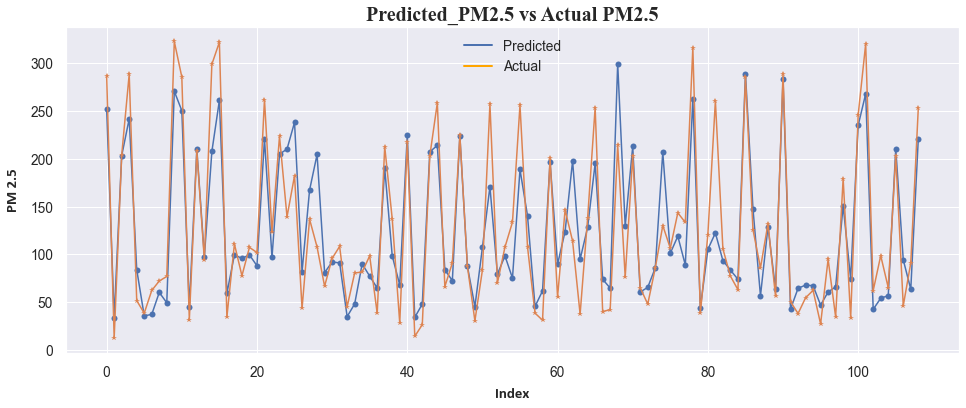

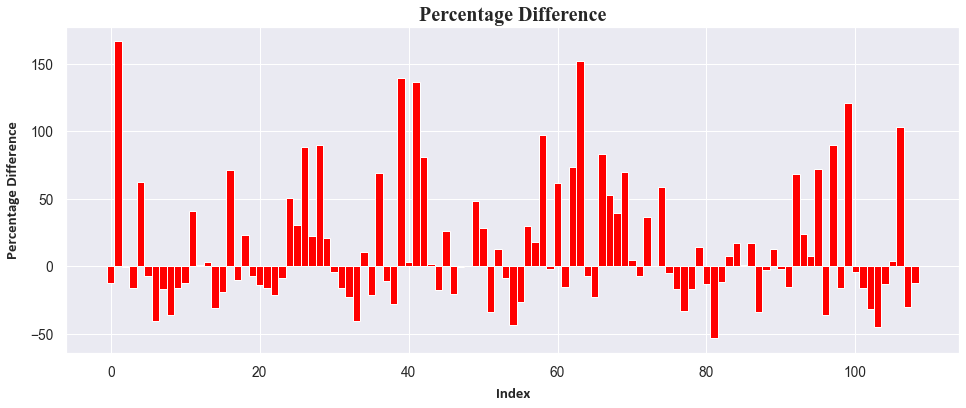

In [39]:
# Graphs to visualize Actual and Predicted Price and their Difference

from matplotlib.lines import Line2D  
fig = plt.figure(figsize = (16,6)) 
x_val = np.arange(len(x_test1))
plt.plot(x_val, final_output_rf['Predicted_PM2.5'].head(len(x_test1)), marker='o')
plt.plot(x_val, final_output_rf['Actual PM2.5'].head(len(x_test1)), marker='*')


plt.title("Predicted_PM2.5 vs Actual PM2.5", fontsize=20, fontweight='bold', fontname='times new roman') 
plt.xlabel("Index", fontsize=15, labelpad=8, fontweight='bold', fontname='calibri')
plt.ylabel("PM 2.5", fontsize=15, labelpad=10, fontweight='bold', fontname='calibri')

# Set the Legends                              
legend_elements = [Line2D([0], [0], color='b', lw=2, label="Predicted"), Line2D([0], [0], color='orange', lw=2, label="Actual")]  
plt.legend(handles=legend_elements)

plt.show()

fig = plt.figure(figsize = (16,6))
plt.bar(x_val, final_output_rf['Percentage Difference'].head(len(x_test1)), width=1, color = "Red")

plt.title("Percentage Difference", fontsize=20, fontweight='bold', fontname='times new roman') 
plt.xlabel("Index", fontsize=15, labelpad=8, fontweight='bold', fontname='calibri')
plt.ylabel("Percentage Difference", fontsize=15, labelpad=10, fontweight='bold', fontname='calibri')
plt.show()

In [40]:
# Save the predictions as a CSV File
final_output_rf.to_csv('Data/RF_Reg_predictions.csv', index = None)
#os.system('Data/RF_Reg_predictions.csv')

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Linear Regression

In [41]:
fit_lr = LinearRegression()

In [42]:
# Model Using SKLEARN
fit_lr.fit(x_train1, y_train1)

LinearRegression()

In [43]:
print("Training Score     : ", fit_lr.score(x_train1, y_train1))
print("Testing Score (R^2): ", fit_lr.score(x_test1, y_test1))

Training Score     :  0.6451697603361379
Testing Score (R^2):  0.730064891086766


In [44]:
y_pred_lr = fit_lr.predict(x_test1)

In [45]:
print('Mean Absolute Error (MAE)            :', metrics.mean_absolute_error(y_test1, y_pred_lr))
print('Mean Squared Error (MSE)             :', metrics.mean_squared_error(y_test1, y_pred_lr))
print('Root Mean Squared Error (RMSE)       :', metrics.mean_squared_error(y_test1, y_pred_lr, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_test1, y_pred_lr))
print('Explained Variance Score             :', metrics.explained_variance_score(y_test1, y_pred_lr))
print('Max Error                            :', metrics.max_error(y_test1, y_pred_lr))
#print('Mean Squared Log Error:', metrics.mean_squared_log_error(y_test1, y_pred_lr))
print('Median Absolute Error                :', metrics.median_absolute_error(y_test1, y_pred_lr))
print('R^2                                  :', metrics.r2_score(y_test1, y_pred_lr))

Mean Absolute Error (MAE)            : 34.47368469085678
Mean Squared Error (MSE)             : 2018.4133492968149
Root Mean Squared Error (RMSE)       : 44.926755383588684
Mean Absolute Percentage Error (MAPE): 0.4094151953778684
Explained Variance Score             : 0.7347785290037301
Max Error                            : 133.5311912861364
Median Absolute Error                : 29.150187324023477
R^2                                  : 0.730064891086766


In [46]:
# Create the Final Output Dataframe

final_output_lr = pd.DataFrame(x_test1)
final_output_lr['Actual PM2.5'] = y_test1
final_output_lr['Predicted_PM2.5'] = y_pred_lr
final_output_lr['Percentage Difference'] = ((final_output_lr['Predicted_PM2.5'] - final_output_lr['Actual PM2.5'])/final_output_lr['Actual PM2.5'])*100

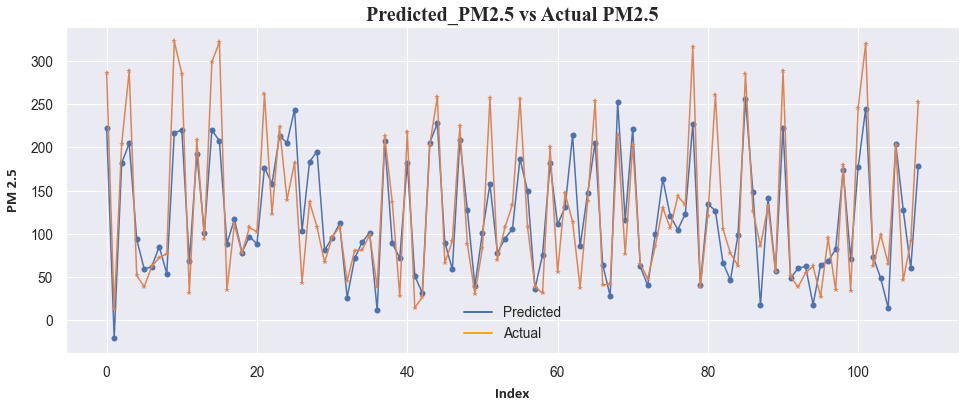

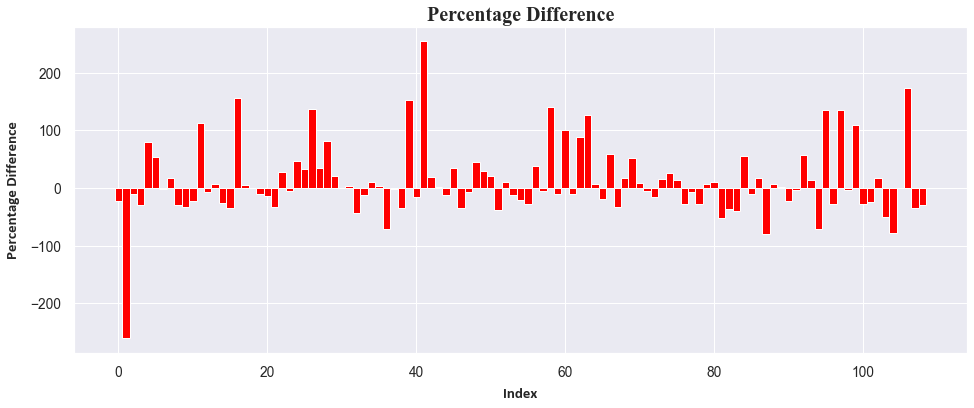

In [47]:
# Graphs to visualize Actual and Predicted Price and their Difference

from matplotlib.lines import Line2D  
fig = plt.figure(figsize = (16,6)) 
x_val = np.arange(len(x_test1))
plt.plot(x_val, final_output_lr['Predicted_PM2.5'].head(len(x_test1)), marker='o')
plt.plot(x_val, final_output_lr['Actual PM2.5'].head(len(x_test1)), marker='*')

plt.title("Predicted_PM2.5 vs Actual PM2.5", fontsize=20, fontweight='bold', fontname='times new roman') 
plt.xlabel("Index", fontsize=15, labelpad=8, fontweight='bold', fontname='calibri')
plt.ylabel("PM 2.5", fontsize=15, labelpad=10, fontweight='bold', fontname='calibri')

# Set the Legends                              
legend_elements = [Line2D([0], [0], color='b', lw=2, label="Predicted"), Line2D([0], [0], color='orange', lw=2, label="Actual")]  
plt.legend(handles=legend_elements)

plt.show()

fig = plt.figure(figsize = (16,6))
plt.bar(x_val, final_output_lr['Percentage Difference'].head(len(x_test1)), width=1, color = "Red")

plt.title("Percentage Difference", fontsize=20, fontweight='bold', fontname='times new roman') 
plt.xlabel("Index", fontsize=15, labelpad=8, fontweight='bold', fontname='calibri')
plt.ylabel("Percentage Difference", fontsize=15, labelpad=10, fontweight='bold', fontname='calibri')
plt.show()

In [48]:
# Save the predictions as a CSV File
final_output_lr.to_csv('Data/Linear_Reg_predictions.csv', index = None)
#os.system('Data/Linear_Reg_predictions.csv')

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Ridge Regression

In [49]:
fit_ridge = Ridge()

In [50]:
# # Hyperparameter Optimization using GridSearchCV

# np.random.seed(42)
# start = time.time()

# param_dist = {'alpha':[0.001, 0.01, 0.1, 0.5, 1, 10, 50, 75, 100, 150, 200, 250, 275, 300, 310, 325, 350, 375, 380],
#               'normalize': [True, False],
#               'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
#               'fit_intercept': [True, False]}

# cv_rr = GridSearchCV(fit_ridge, cv = 10,
#                      param_grid=param_dist, 
#                      n_jobs = -1)         # n_jobs should be 1 less than number of CPU cores or -1 to use all available cores

# cv_rr.fit(x_train1, y_train1)
# print('Best Parameters using grid search: \n', cv_rr.best_params_)
# end = time.time()
# print('Time taken in grid search: {0: .2f}'.format(end - start))

In [51]:
fit_ridge.set_params(alpha = 0.5,
                    fit_intercept = True,
                    normalize = False,
                    solver = 'saga')

Ridge(alpha=0.5, normalize=False, solver='saga')

In [52]:
fit_ridge.fit(x_train1,y_train1)

Ridge(alpha=0.5, normalize=False, solver='saga')

In [53]:
y_pred_ridge = fit_ridge.predict(x_test1)
print("Training Score: ", fit_ridge.score(x_train1,y_train1))
print("Testing Score : ", fit_ridge.score(x_test1,y_test1))

Training Score:  0.6451681928093438
Testing Score :  0.7299169048912104


In [54]:
print('Mean Absolute Error (MAE)            :', metrics.mean_absolute_error(y_test1, y_pred_ridge))
print('Mean Squared Error (MSE)             :', metrics.mean_squared_error(y_test1, y_pred_ridge))
print('Root Mean Squared Error (RMSE)       :', metrics.mean_squared_error(y_test1, y_pred_ridge, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_test1, y_pred_ridge))
print('Explained Variance Score             :', metrics.explained_variance_score(y_test1, y_pred_ridge))
print('Max Error                            :', metrics.max_error(y_test1, y_pred_ridge))
print('Median Absolute Error                :', metrics.median_absolute_error(y_test1, y_pred_ridge))
print('R^2                                  :', metrics.r2_score(y_test1, y_pred_ridge))

Mean Absolute Error (MAE)            : 34.479020700166885
Mean Squared Error (MSE)             : 2019.5199015857097
Root Mean Squared Error (RMSE)       : 44.9390687663386
Mean Absolute Percentage Error (MAPE): 0.40936456425057743
Explained Variance Score             : 0.7346543734036406
Max Error                            : 133.5247426181259
Median Absolute Error                : 29.28513728741251
R^2                                  : 0.7299169048912104


In [55]:
# Create the Final Output Dataframe

final_output_ridge = pd.DataFrame(x_test1)
final_output_ridge['Actual PM2.5'] = y_test1
final_output_ridge['Predicted_PM2.5'] = y_pred_ridge
final_output_ridge['Percentage Difference'] = ((final_output_ridge['Predicted_PM2.5'] - final_output_ridge['Actual PM2.5'])/final_output_ridge['Actual PM2.5'])*100

In [56]:
x_val = np.arange(len(x_test1))

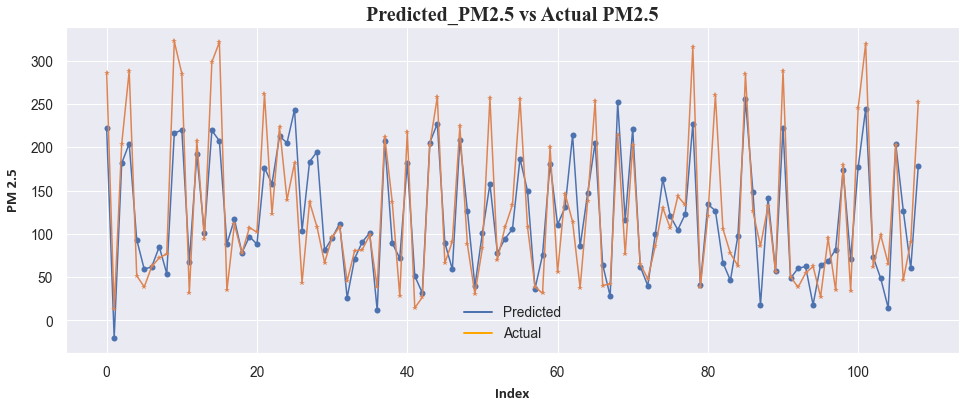

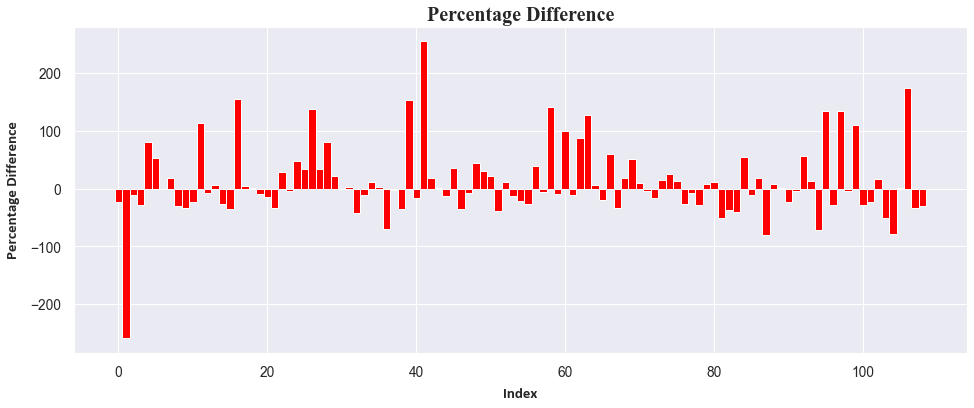

In [57]:
# Graphs to visualize Actual and Predicted Price and their Difference

from matplotlib.lines import Line2D  
fig = plt.figure(figsize = (16,6)) 
x_val = np.arange(len(x_test1))
plt.plot(x_val, final_output_ridge['Predicted_PM2.5'].head(len(x_test1)), marker='o')
plt.plot(x_val, final_output_ridge['Actual PM2.5'].head(len(x_test1)), marker='*')


plt.title("Predicted_PM2.5 vs Actual PM2.5", fontsize=20, fontweight='bold', fontname='times new roman') 
plt.xlabel("Index", fontsize=15, labelpad=8, fontweight='bold', fontname='calibri')
plt.ylabel("PM 2.5", fontsize=15, labelpad=10, fontweight='bold', fontname='calibri')

# Set the Legends                              
legend_elements = [Line2D([0], [0], color='b', lw=2, label="Predicted"), Line2D([0], [0], color='orange', lw=2, label="Actual")]  
plt.legend(handles=legend_elements)

plt.show()

fig = plt.figure(figsize = (16,6))
plt.bar(x_val, final_output_ridge['Percentage Difference'].head(len(x_test1)), width=1, color = "Red")

plt.title("Percentage Difference", fontsize=20, fontweight='bold', fontname='times new roman') 
plt.xlabel("Index", fontsize=15, labelpad=8, fontweight='bold', fontname='calibri')
plt.ylabel("Percentage Difference", fontsize=15, labelpad=10, fontweight='bold', fontname='calibri')
plt.show()

In [58]:
# Save the final output as a CSV File
final_output_ridge.to_csv('Data/Ridge_reg_predictions.csv', index = None)
# os.system('Data/Linear_reg_predictions.csv')

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Lasso Regression

In [59]:
fit_lasso = Lasso()

In [60]:
# Hyperparameter Optimization using GridSearchCV

np.random.seed(42)
start = time.time()

param_dist = {'alpha':[0.18, 0.2, 0.22, 0.24, 0.26, 0.28]}

cv_lr = GridSearchCV(fit_lasso, cv = 10,
                     param_grid=param_dist, 
                     n_jobs = -1)         # n_jobs should be 1 less than number of CPU cores or -1 to use all available cores

cv_lr.fit(x_train1, y_train1)
print('Best Parameters using grid search: \n', cv_lr.best_params_)
end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))

Best Parameters using grid search: 
 {'alpha': 0.24}
Time taken in grid search:  0.75


In [61]:
fit_lasso.set_params(alpha = 0.24)

Lasso(alpha=0.24)

In [62]:
fit_lasso.fit(x_train1,y_train1)

Lasso(alpha=0.24)

In [63]:
y_pred_lasso = fit_lasso.predict(x_test1)
print("Training Score: ", fit_lasso.score(x_train1,y_train1))
print("Testing Score : ", fit_lasso.score(x_test1,y_test1))

Training Score:  0.6451100939157279
Testing Score :  0.7291959747618677


In [64]:
print('Mean Absolute Error (MAE)            :', metrics.mean_absolute_error(y_test1, y_pred_lasso))
print('Mean Squared Error (MSE)             :', metrics.mean_squared_error(y_test1, y_pred_lasso))
print('Root Mean Squared Error (RMSE)       :', metrics.mean_squared_error(y_test1, y_pred_lasso, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_test1, y_pred_lasso))
print('Explained Variance Score             :', metrics.explained_variance_score(y_test1, y_pred_lasso))
print('Max Error                            :', metrics.max_error(y_test1, y_pred_lasso))
print('Median Absolute Error                :', metrics.median_absolute_error(y_test1, y_pred_lasso))
print('R^2                                  :', metrics.r2_score(y_test1, y_pred_lasso))

Mean Absolute Error (MAE)            : 34.51026396697328
Mean Squared Error (MSE)             : 2024.9105860462614
Root Mean Squared Error (RMSE)       : 44.999006500658005
Mean Absolute Percentage Error (MAPE): 0.41008035587098446
Explained Variance Score             : 0.7339658869807704
Max Error                            : 133.74240417598793
Median Absolute Error                : 29.806561939088795
R^2                                  : 0.7291959747618677


In [65]:
# Create the Final Output Dataframe

final_output_lasso = pd.DataFrame(x_test1)
final_output_lasso['Actual PM2.5'] = y_test1
final_output_lasso['Predicted_PM2.5'] = y_pred_lasso
final_output_lasso['Percentage Difference'] = ((final_output_lasso['Predicted_PM2.5'] - final_output_lasso['Actual PM2.5'])/final_output_lasso['Actual PM2.5'])*100

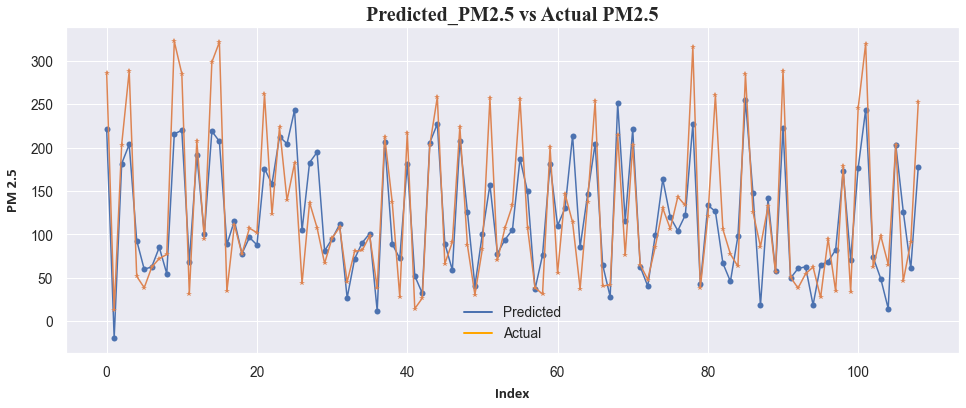

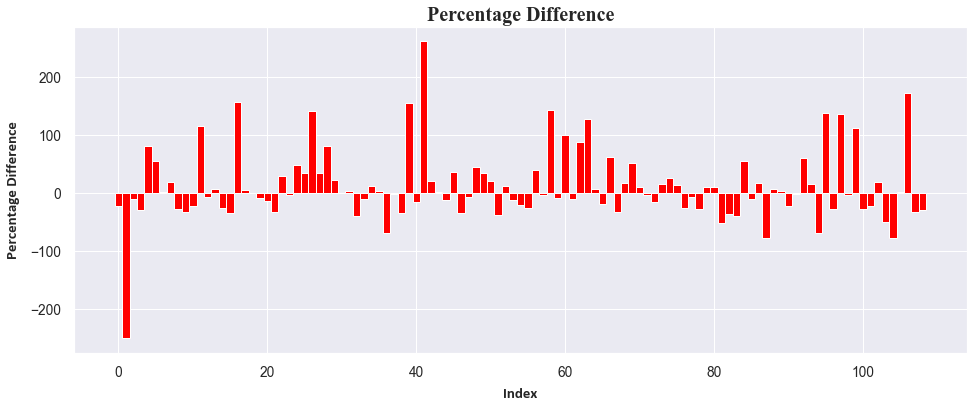

In [66]:
# Graphs to visualize Actual and Predicted Price and their Difference

from matplotlib.lines import Line2D  
fig = plt.figure(figsize = (16,6)) 
x_val = np.arange(len(x_test1))
plt.plot(x_val, final_output_lasso['Predicted_PM2.5'].head(len(x_test1)), marker='o')
plt.plot(x_val, final_output_lasso['Actual PM2.5'].head(len(x_test1)), marker='*')


plt.title("Predicted_PM2.5 vs Actual PM2.5", fontsize=20, fontweight='bold', fontname='times new roman') 
plt.xlabel("Index", fontsize=15, labelpad=8, fontweight='bold', fontname='calibri')
plt.ylabel("PM 2.5", fontsize=15, labelpad=10, fontweight='bold', fontname='calibri')

# Set the Legends                              
legend_elements = [Line2D([0], [0], color='b', lw=2, label="Predicted"), Line2D([0], [0], color='orange', lw=2, label="Actual")]  
plt.legend(handles=legend_elements)

plt.show()

fig = plt.figure(figsize = (16,6))
plt.bar(x_val, final_output_lasso['Percentage Difference'].head(len(x_test1)), width=1, color = "Red")

plt.title("Percentage Difference", fontsize=20, fontweight='bold', fontname='times new roman') 
plt.xlabel("Index", fontsize=15, labelpad=8, fontweight='bold', fontname='calibri')
plt.ylabel("Percentage Difference", fontsize=15, labelpad=10, fontweight='bold', fontname='calibri')
plt.show()

In [67]:
# Save the final output as a CSV File
final_output_lasso.to_csv('Data/Lasso_reg_predictions.csv', index = None)
# os.system('Data/Lasso_reg_predictions.csv')

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Polynomial Features with Linear Regression

In [68]:
# STEP 1: Determining the degree of the polynomial

poly = PolynomialFeatures(degree = 2, include_bias=False)

# degree sets the degree of our polynomial function. degree=5 means that we want to work with a 5th degree polynomial:
# y = ß0 + ß1x + ß2x2

# include_bias should be set to False, because we’ll use PolynomialFeatures together with LinearRegression() later on

In [69]:
# STEP 2: Creating the new features and performing test train split with the new features

X = poly.fit_transform(x)
x_train2, x_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state = 42)

In [70]:
# STEP 3: Creating the polynomial regression model

fit_poly = LinearRegression()
fit_poly.fit(x_train2, y_train2)

LinearRegression()

In [71]:
y_pred_poly = fit_poly.predict(x_test2)
print("Training Score: ", fit_poly.score(x_train2,y_train2))
print("Testing Score : ", fit_poly.score(x_test2,y_test2))

Training Score:  0.72180581802525
Testing Score :  0.7998820199544082


In [72]:
print('Mean Absolute Error (MAE)            :', metrics.mean_absolute_error(y_test2, y_pred_poly))
print('Mean Squared Error (MSE)             :', metrics.mean_squared_error(y_test2, y_pred_poly))
print('Root Mean Squared Error (RMSE)       :', metrics.mean_squared_error(y_test2, y_pred_poly, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_test2, y_pred_poly))
print('Explained Variance Score             :', metrics.explained_variance_score(y_test2, y_pred_poly))
print('Max Error                            :', metrics.max_error(y_test2, y_pred_poly))
print('Median Absolute Error                :', metrics.median_absolute_error(y_test2, y_pred_poly))
print('R^2                                  :', metrics.r2_score(y_test2, y_pred_poly))

Mean Absolute Error (MAE)            : 29.360481965510413
Mean Squared Error (MSE)             : 1496.3626035328718
Root Mean Squared Error (RMSE)       : 38.68284637320361
Mean Absolute Percentage Error (MAPE): 0.3432903601060621
Explained Variance Score             : 0.8010715079754375
Max Error                            : 150.18239202689801
Median Absolute Error                : 23.407497299769837
R^2                                  : 0.7998820199544082


In [73]:
# Create the Final Output Dataframe

final_output_poly = pd.DataFrame(x_test2)
final_output_poly['Actual PM2.5'] = y_test2
final_output_poly['Predicted_PM2.5'] = y_pred_poly
final_output_poly['Percentage Difference'] = ((final_output_poly['Predicted_PM2.5'] - final_output_poly['Actual PM2.5'])/final_output_poly['Actual PM2.5'])*100

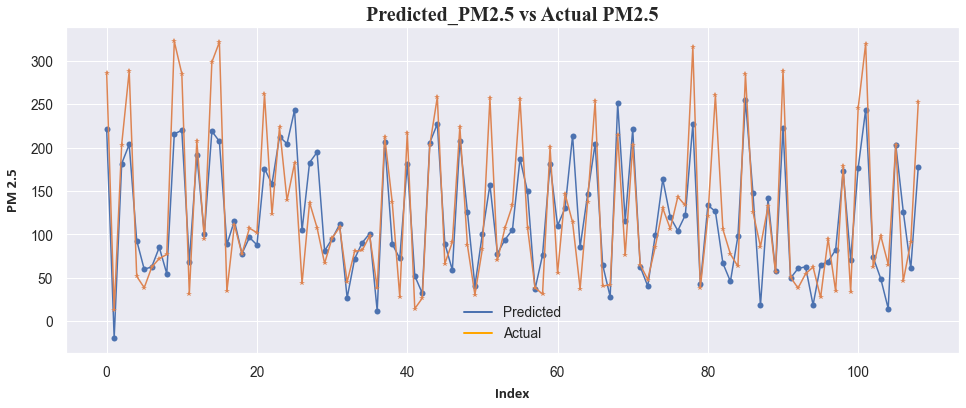

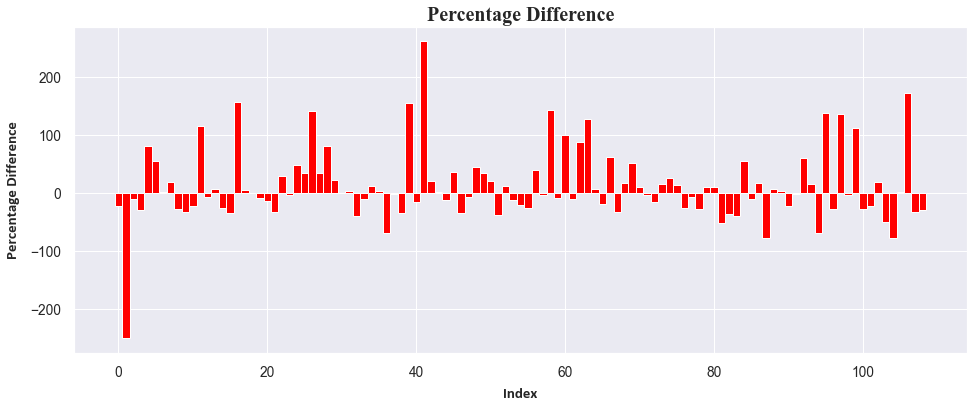

In [74]:
# Graphs to visualize Actual and Predicted Price and their Difference

from matplotlib.lines import Line2D  
fig = plt.figure(figsize = (16,6)) 
x_val = np.arange(len(x_test2))
plt.plot(x_val, final_output_lasso['Predicted_PM2.5'].head(len(x_test2)), marker='o')
plt.plot(x_val, final_output_lasso['Actual PM2.5'].head(len(x_test2)), marker='*')


plt.title("Predicted_PM2.5 vs Actual PM2.5", fontsize=20, fontweight='bold', fontname='times new roman') 
plt.xlabel("Index", fontsize=15, labelpad=8, fontweight='bold', fontname='calibri')
plt.ylabel("PM 2.5", fontsize=15, labelpad=10, fontweight='bold', fontname='calibri')

# Set the Legends                              
legend_elements = [Line2D([0], [0], color='b', lw=2, label="Predicted"), Line2D([0], [0], color='orange', lw=2, label="Actual")]  
plt.legend(handles=legend_elements)

plt.show()

fig = plt.figure(figsize = (16,6))
plt.bar(x_val, final_output_lasso['Percentage Difference'].head(len(x_test2)), width=1, color = "Red")

plt.title("Percentage Difference", fontsize=20, fontweight='bold', fontname='times new roman') 
plt.xlabel("Index", fontsize=15, labelpad=8, fontweight='bold', fontname='calibri')
plt.ylabel("Percentage Difference", fontsize=15, labelpad=10, fontweight='bold', fontname='calibri')
plt.show()

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Support Vector Regressor

In [75]:
# Execute this code snippet only to find the optimal values of parameters. Comment it out afterwards
# Linear Kernel:
svr=SVR(kernel='linear')
svr.fit(x_train1,y_train1)
y_pred_svr=svr.predict(x_test1)
print("Training Score with linear kernel: ", svr.score(x_train1,y_train1))
print("Testing Score with linear kernel : ", svr.score(x_test1,y_test1))

# Polynomial Kernel:
svr=SVR(kernel='poly')
svr.fit(x_train1,y_train1)
y_pred_svr=svr.predict(x_test1)
print("\nTraining Score with polynomial kernel: ", svr.score(x_train1,y_train1))
print("Testing Score with polynomial kernel : ", svr.score(x_test1,y_test1))

# rbf Kernel:
svr=SVR(kernel='rbf')
svr.fit(x_train1,y_train1)
y_pred_svr=svr.predict(x_test1)
print("\nTraining Score with rbf kernel: ", svr.score(x_train1,y_train1))
print("Testing Score with rbf kernel : ", svr.score(x_test1,y_test1))

# sigmoid Kernel:
svr=SVR(kernel='sigmoid')
svr.fit(x_train1,y_train1)
y_pred_svr=svr.predict(x_test1)
print("\nTraining Score with sigmoid kernel: ", svr.score(x_train1,y_train1))
print("Testing Score with sigmoid kernel : ", svr.score(x_test1,y_test1))

# Insights: 'Linear' kernel gives the best accuracy

Training Score with linear kernel:  0.6202218475328842
Testing Score with linear kernel :  0.6796585955123386

Training Score with polynomial kernel:  0.39984356281638445
Testing Score with polynomial kernel :  0.46325253509149633

Training Score with rbf kernel:  0.39301044917335815
Testing Score with rbf kernel :  0.36972070765043397

Training Score with sigmoid kernel:  0.4978515352638564
Testing Score with sigmoid kernel :  0.5059127729403337


# Hyperparameter Optimization using GridSearchCV

In [76]:
svr = SVR()
scorer = make_scorer(r2_score, greater_is_better=True)
parameters = [{'kernel': ['linear'], 
               'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
               'C': [0.01, 0.1, 1, 3, 5, 7, 10, 15, 20],
               'epsilon': [0.01, 0.1, 0.5, 1, 2, 3, 5, 7, 10]}]

fit_svr = GridSearchCV(svr, parameters, cv = 10, scoring=scorer, n_jobs=-1)

fit_svr.fit(x_train1, y_train1)
print("R Squared: ", fit_svr.best_score_)
print("Parameters: ", fit_svr.best_params_)

R Squared:  0.6137581042373952
Parameters:  {'C': 3, 'epsilon': 5, 'gamma': 1e-05, 'kernel': 'linear'}


In [77]:
svc_model= SVR()
tuned_parameters = {'C': [3] , 'kernel': ['linear'], 'gamma': [0.0001], 'epsilon': [5]}
fit_svr = GridSearchCV(svc_model, tuned_parameters, cv=10, scoring=scorer, n_jobs = -1)
fit_svr.fit(x_train1, y_train1)
print("R Squared: ", fit_svr.best_score_)
print("Parameters: ", fit_svr.best_params_)

R Squared:  0.6137581042373952
Parameters:  {'C': 3, 'epsilon': 5, 'gamma': 0.0001, 'kernel': 'linear'}


In [78]:
y_pred_svr = fit_svr.predict(x_test1)
print("Training Score: ", fit_svr.score(x_train1,y_train1))
print("Testing Score : ", fit_svr.score(x_test1,y_test1))

Training Score:  0.6273285161130908
Testing Score :  0.6884131788369454


In [79]:
print('Mean Absolute Error (MAE)            :', metrics.mean_absolute_error(y_test1, y_pred_svr))
print('Mean Squared Error (MSE)             :', metrics.mean_squared_error(y_test1, y_pred_svr))
print('Root Mean Squared Error (RMSE)       :', metrics.mean_squared_error(y_test1, y_pred_svr, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(y_test1, y_pred_svr))
print('Explained Variance Score             :', metrics.explained_variance_score(y_test1, y_pred_svr))
print('Max Error                            :', metrics.max_error(y_test1, y_pred_svr))
print('Median Absolute Error                :', metrics.median_absolute_error(y_test1, y_pred_svr))
print('R^2                                  :', metrics.r2_score(y_test1, y_pred_svr))

Mean Absolute Error (MAE)            : 35.81421521895185
Mean Squared Error (MSE)             : 2329.859949794902
Root Mean Squared Error (RMSE)       : 48.26862282886163
Mean Absolute Percentage Error (MAPE): 0.3716254380626559
Explained Variance Score             : 0.7164053649213122
Max Error                            : 141.88182032023263
Median Absolute Error                : 27.1532892949689
R^2                                  : 0.6884131788369454


In [80]:
# Create the Final Output Dataframe

final_output_svr = pd.DataFrame(x_test1)
final_output_svr['Actual PM2.5'] = y_test1
final_output_svr['Predicted_PM2.5'] = y_pred_svr
final_output_svr['Percentage Difference'] = ((final_output_svr['Predicted_PM2.5'] - final_output_svr['Actual PM2.5'])/final_output_svr['Actual PM2.5'])*100

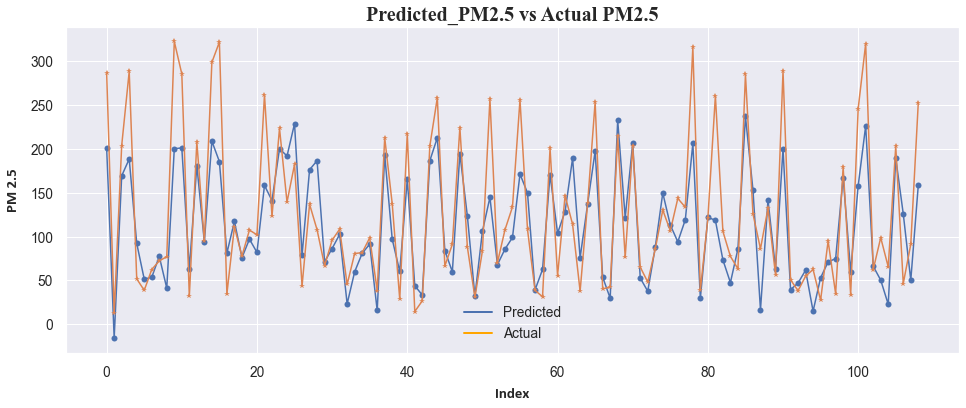

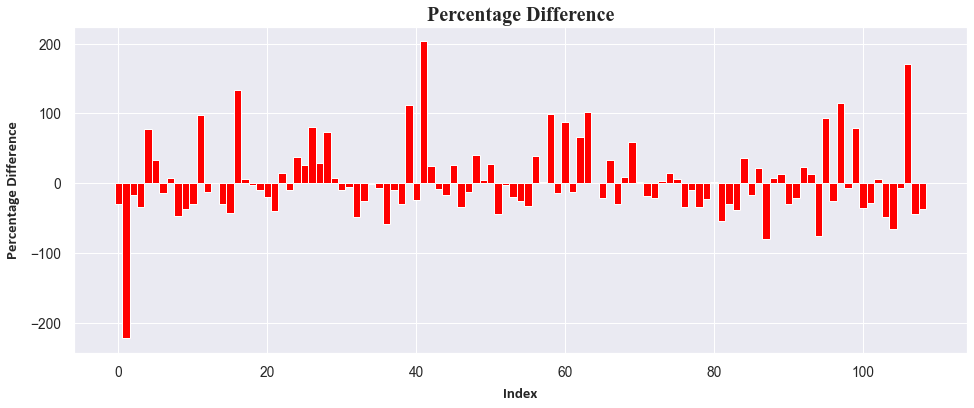

In [81]:
# Graphs to visualize Actual and Predicted Price and their Difference

from matplotlib.lines import Line2D  
fig = plt.figure(figsize = (16,6)) 
x_val = np.arange(len(x_test1))
plt.plot(x_val, final_output_svr['Predicted_PM2.5'].head(len(x_test1)), marker='o')
plt.plot(x_val, final_output_svr['Actual PM2.5'].head(len(x_test1)), marker='*')


plt.title("Predicted_PM2.5 vs Actual PM2.5", fontsize=20, fontweight='bold', fontname='times new roman') 
plt.xlabel("Index", fontsize=15, labelpad=8, fontweight='bold', fontname='calibri')
plt.ylabel("PM 2.5", fontsize=15, labelpad=10, fontweight='bold', fontname='calibri')

# Set the Legends                              
legend_elements = [Line2D([0], [0], color='b', lw=2, label="Predicted"), Line2D([0], [0], color='orange', lw=2, label="Actual")]  
plt.legend(handles=legend_elements)

plt.show()

fig = plt.figure(figsize = (16,6))
plt.bar(x_val, final_output_svr['Percentage Difference'].head(len(x_test1)), width=1, color = "Red")

plt.title("Percentage Difference", fontsize=20, fontweight='bold', fontname='times new roman') 
plt.xlabel("Index", fontsize=15, labelpad=8, fontweight='bold', fontname='calibri')
plt.ylabel("Percentage Difference", fontsize=15, labelpad=10, fontweight='bold', fontname='calibri')
plt.show()

# Error, Accuracy and RMSE Comparison Between Models

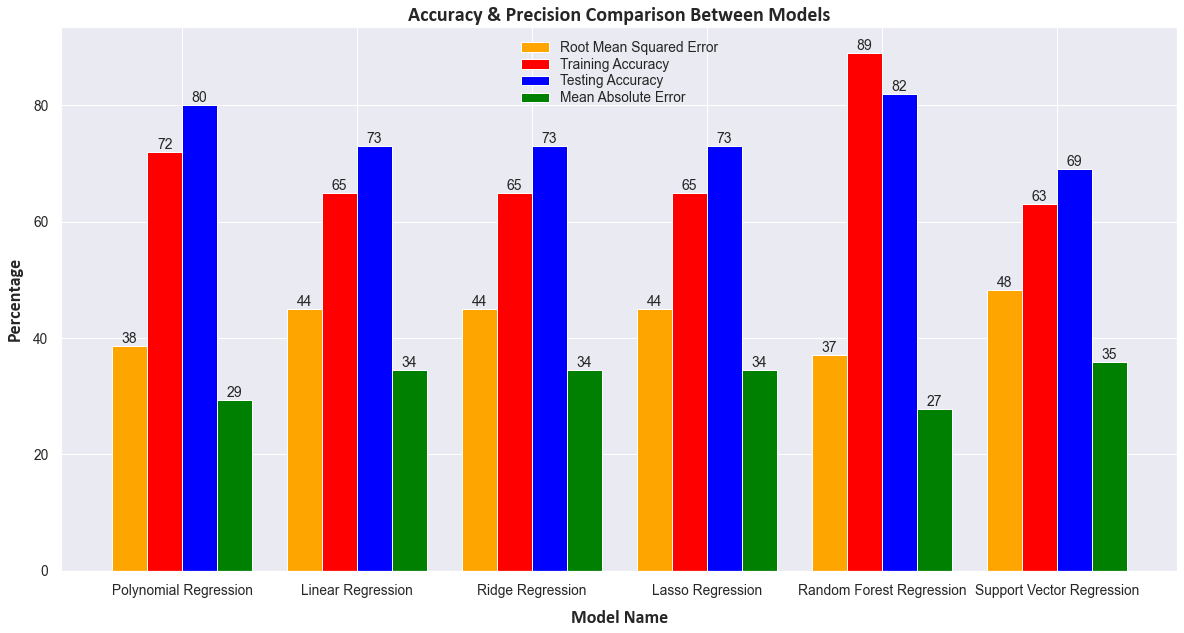

In [82]:
# Create a list of tuples with Mean Test Accuracy of all models:
acc_comparison_test = [('Polynomial Regression', (fit_poly.score(x_test2,y_test2)*100).round()), 
                  ('Linear Regression', (fit_lr.score(x_test1,y_test1)*100).round()), 
                  ('Ridge Regression', (fit_ridge.score(x_test1,y_test1)*100).round()), 
                  ('Lasso Regression', (fit_lasso.score(x_test1,y_test1)*100).round()), 
                  ('Random Forest Regression', (fit_rf.score(x_test1,y_test1)*100).round()),
                  ('Support Vector Regression', (fit_svr.score(x_test1,y_test1)*100).round())]
acc_comparison_test = dict(acc_comparison_test)

# Create a list of tuples with Mean Train Accuracy of all models:
acc_comparison_train = [('Polynomial Regression', (fit_poly.score(x_train2,y_train2)*100).round()), 
                  ('Linear Regression', (fit_lr.score(x_train1,y_train1)*100).round()), 
                  ('Ridge Regression', (fit_ridge.score(x_train1,y_train1)*100).round()), 
                  ('Lasso Regression', (fit_lasso.score(x_train1,y_train1)*100).round()), 
                  ('Random Forest Regression', (fit_rf.score(x_train1,y_train1)*100).round()),
                  ('Support Vector Regression', (fit_svr.score(x_train1,y_train1)*100).round())]
acc_comparison_train = dict(acc_comparison_train)

# Create a list of tuples with Mean Absolute Error of all models:
mae_comparison = [('Polynomial Regression', metrics.mean_absolute_error(y_test2, y_pred_poly)), 
                  ('Linear Regression', metrics.mean_absolute_error(y_test1, y_pred_lr)), 
                  ('Ridge Regression', metrics.mean_absolute_error(y_test1, y_pred_ridge)), 
                  ('Lasso Regression', metrics.mean_absolute_error(y_test1, y_pred_lasso)), 
                  ('Random Forest Regression', metrics.mean_absolute_error(y_test1, y_pred_rf)),
                  ('Support Vector Regression', metrics.mean_absolute_error(y_test1, y_pred_svr))]
mae_comparison = dict(mae_comparison)

# Create a list of tuples with Root Mean Squared Error of all models:
rmse_comparison = [('Polynomial Regression', metrics.mean_squared_error(y_test2, y_pred_poly, squared=False)), 
                   ('Linear Regression', metrics.mean_squared_error(y_test1, y_pred_lr, squared=False)), 
                   ('Ridge Regression', metrics.mean_squared_error(y_test1, y_pred_ridge, squared=False)), 
                   ('Lasso Regression', metrics.mean_squared_error(y_test1, y_pred_lasso, squared=False)), 
                   ('Random Forest Regression',metrics.mean_squared_error(y_test1, y_pred_rf, squared=False)),
                   ('Support Vector Regression',metrics.mean_squared_error(y_test1, y_pred_svr, squared=False))]
rmse_comparison = dict(rmse_comparison)

# Plot a bar graph to compare the result
fig = plt.figure(figsize = (20,10))
X_axis = np.arange(len(acc_comparison_test.keys()))  

plt.bar(X_axis - 0.3, rmse_comparison.values(), 0.2, color = "Orange", label = "Root Mean Squared Error")
plt.bar(X_axis - 0.1, acc_comparison_train.values(), 0.2, color = "Red", label = "Training Accuracy")
plt.bar(X_axis + 0.1, acc_comparison_test.values(), 0.2, color = "Blue", label = "Testing Accuracy")
plt.bar(X_axis + 0.3, mae_comparison.values(), 0.2, color = "Green", label = "Mean Absolute Error")

# Add Labels
plt.xticks(X_axis, acc_comparison_train.keys())
plt.title("Accuracy & Precision Comparison Between Models", fontsize=20, fontweight='bold', fontname='calibri')
plt.xlabel("Model Name", fontsize=18, labelpad=12, fontweight='bold', fontname='calibri')
plt.ylabel("Percentage", fontsize=18, labelpad=10, fontweight='bold', fontname='calibri')

lst1 = list(acc_comparison_train.values())
lst2 = list(acc_comparison_test.values())
model_lst = list(acc_comparison_train.keys())
lst3 = list(mae_comparison.values())
lst4 = list(rmse_comparison.values())

# Annotate the bars with values
for i in range(len(lst1)):
    plt.annotate(int(lst4[i]), xy=(i-0.3, lst4[i]), ha='center', va='bottom', fontsize = 14)
    plt.annotate(int(lst1[i]), xy=(i-0.1, lst1[i]), ha='center', va='bottom', fontsize = 14)
    plt.annotate(int(lst2[i]), xy=(i+0.1, lst2[i]), ha='center', va='bottom', fontsize = 14)
    plt.annotate(int(lst3[i]), xy=(i+0.3, lst3[i]), ha='center', va='bottom', fontsize = 14)
    
# Add Legend    
plt.legend(loc='upper center', borderpad=1, borderaxespad=0, labelspacing=0.2)

# Insights: Random Forest Regressor consistently produces the highest Accuracy and Lowest Error
# followed by Polynomial Regression 
# Linear, Ridge and Lasso Regression gives the same result

# Saving the Model

In [83]:
import joblib

joblib.dump(fit_rf, 'Data/aqi_model_rf.pkl')

['Data/aqi_model_rf.pkl']

# Loading the Model

In [84]:
model = joblib.load('Data/aqi_model_rf.pkl')

In [85]:
# Create a test dataframe to feed to the loaded moded to verify it's performance manually
test_df = final_df.drop(['PM2.5'], axis = 1).reset_index().drop(['index'], axis = 1)
test_df.head(5)

,Average Temperature,Average relative humidity,Total rainfall and / or snowmelt (mm),Average visibility (Km),Average wind speed (Km/h)
0,9.1,90.0,0.0,0.5,0.0
1,7.4,93.0,0.0,0.5,4.3
2,7.8,87.0,0.0,0.6,4.4
3,6.7,82.0,0.0,0.6,4.8
4,8.6,72.0,0.0,0.8,8.1


In [86]:
list(test_df.loc[7])

[13.4, 87.0, 0.0, 0.5, 1.5]

In [87]:
data = list(test_df.loc[7])
data
data = [5.6, 98.0, 0.9, 0.1, 1.2]

In [88]:
new_data_std = preprocessing.scale(data)
new_data_std

array([-0.40449322,  1.99751024, -0.52667305, -0.54746962, -0.51887434])

In [89]:
model.predict([new_data_std])

array([94.25104684])